<a href="https://colab.research.google.com/github/gauravreddy08/learning-pytorch/blob/main/04_pytorch_custom_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04 | **PyTorch** Custom Datasets
https://www.learnpytorch.io/04_pytorch_custom_datasets/

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {device}")

Device: cuda


## Getting **data**

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it... 
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)
    
    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...") 
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


## Becoming ***one*** with the data

In [3]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/test/steak/1285886.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/3424937.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/1882831.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/2144308.jpg'),
 PosixPath('data/pizza_steak_sushi/test/steak/966174.jpg')]

In [4]:
train_dir = image_path / "train"
test_dir = image_path / "test"

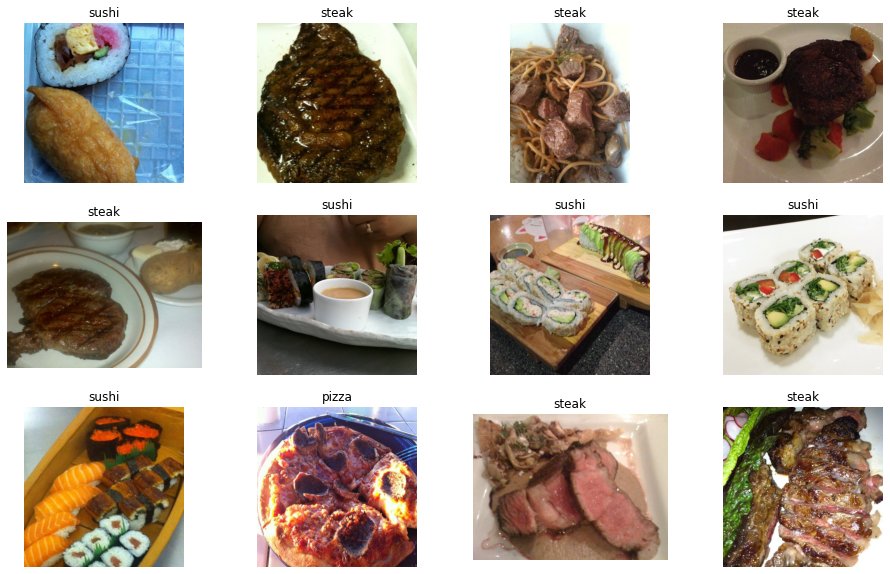

In [5]:
rows, cols = 3, 4

plt.figure(figsize = (16, 10))

for i in range(1, rows*cols+1):
  fpath = random.choice(image_path_list)
  label = fpath.parent.stem

  plt.subplot(rows, cols, i)
  plt.imshow(Image.open(fpath))
  plt.title(label)
  plt.axis('off')

### **Transforming** our data

In [6]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [7]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

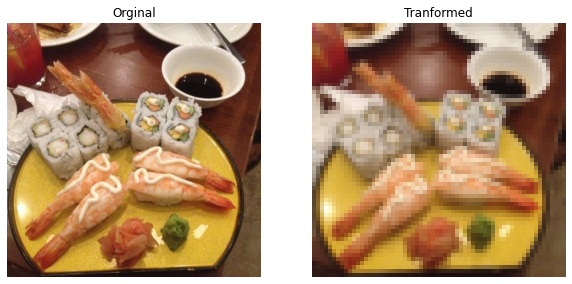

In [8]:
plt.figure(figsize=(10, 5))
fpath = random.choice(image_path_list)

plt.subplot(1, 2, 1)
plt.imshow(Image.open(fpath))
plt.title("Orginal")
plt.axis('off');

plt.subplot(1, 2, 2)
plt.imshow(data_transform(Image.open(fpath)).permute(1, 2, 0))
plt.title("Tranformed")
plt.axis('off');

## Loading the image **data**

In [9]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)

In [10]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [11]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

Dataloaders...

In [12]:
train_dataloader = DataLoader(train_data,
                              batch_size=32, shuffle=True)

test_dataloader = DataLoader(test_data,
                              batch_size=32, shuffle=False)

## Same with **custom** code

In [13]:
from typing import Tuple, Dict, List
import os

In [14]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted([entry.name for entry in os.scandir(directory)])
  class_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_idx

In [15]:
class_names, class_to_idx = find_classes(train_dir)
class_names, class_to_idx 

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### Replicating **`ImageFolder`**

In [16]:
from torch.utils.data import Dataset
from pathlib import Path

class ImageFolderCustom(Dataset):
  def __init__(self, target_dir, transform=None):
    self.paths = list(target_dir.glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.classes_to_idx = find_classes(target_dir)

  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return (len(self.paths))

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
     img = self.load_image(index)
     class_name = self.paths[index].parent.stem
     if self.transform:
       return self.transform(img), self.classes_to_idx[class_name]
     else:
       return transforms.ToTensor(img), self.classes_to_idx[class_name]

In [17]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [18]:
train_data_custom = ImageFolderCustom(train_dir, train_transforms)
train_dataloader = DataLoader(train_data_custom,
                              batch_size=32, shuffle=True)

test_data_custom = ImageFolderCustom(test_dir, test_transforms)
test_dataloader = DataLoader(test_data_custom,
                              batch_size=32, shuffle=False)


train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f83b61b5400>,
 <torch.utils.data.dataloader.DataLoader at 0x7f83b6213670>)

In [19]:
next(iter(train_dataloader))

[tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0471,  ..., 0.0471, 0.0039, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0078,  ..., 0.0196, 0.0039, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0039,  ..., 0.0039, 0.0000, 0.0000],
           [0.0000, 0.0039, 0.0118,  ..., 0.0157, 0.0039, 0.0000],
           ...,
           [0.0000, 0.0000, 0.0039,  ..., 0.0392, 0.0039, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
          [[0.0078, 0.0078, 0.0078,  ..., 0.0078, 0.0078, 0.0078],
           [0.0078, 0.0078, 0.0118,  ..., 0.0078, 0.0078, 0.0078],
           [0.0078, 0.00

yayy.. it's working...

### Other forms of ***tranforms*** (Data Augmentation)

#### Trivial Augment

In [20]:
train_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

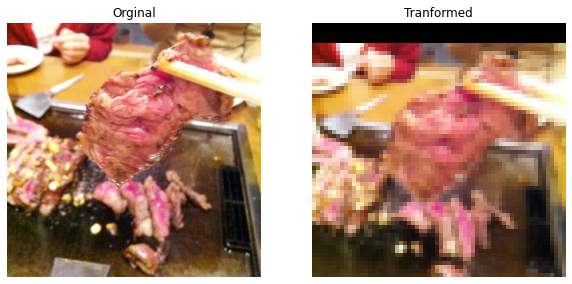

In [21]:
plt.figure(figsize=(10, 5))
fpath = random.choice(image_path_list)

plt.subplot(1, 2, 1)
plt.imshow(Image.open(fpath))
plt.title("Orginal")
plt.axis('off');

plt.subplot(1, 2, 2)
plt.imshow(train_transform(Image.open(fpath)).permute(1, 2, 0))
plt.title("Tranformed")
plt.axis('off');

In [22]:
train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

# train
train_data_custom = ImageFolderCustom(train_dir, train_transforms)
train_dataloader = DataLoader(train_data_custom,
                              batch_size=32, shuffle=True)
# test
test_data_custom = ImageFolderCustom(test_dir, test_transforms)
test_dataloader = DataLoader(test_data_custom,
                              batch_size=32, shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f83b629c0a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f83b61a2b50>)

## Building the **model**

In [23]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape, output_shape, hidden_units):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*16*16,
                  out_features = output_shape)

    )
  def forward(self, x: torch.Tensor):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = self.classifier(x)

    return x

In [24]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = device):
  train_loss = 0
  train_acc = 0

  from sklearn.metrics import accuracy_score
  
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    preds = model(X)
    loss = loss_fn(preds, y)
    
    train_loss+=loss
    train_acc += accuracy_score(y.cpu(), torch.argmax(torch.softmax(preds, dim=1), dim=1).cpu())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return train_loss/len(dataloader), train_acc/len(dataloader)

def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device: torch.device = device):
  test_loss = 0
  test_acc = 0

  from sklearn.metrics import accuracy_score
  
  model.eval()
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      preds = model(X)
      test_loss += loss_fn(preds, y)
      test_acc += accuracy_score(y.cpu(), torch.argmax(torch.softmax(preds, dim=1), dim=1).cpu())
    return test_loss/len(dataloader), test_acc/len(dataloader)

In [25]:
torch.manual_seed(42)

model_0 = TinyVGG(input_shape=3, hidden_units=10, 
                  output_shape=len(class_names)).to(device)

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### Passing *dummy* data through model, to infer the appropriate shape

In [27]:
dummy_data = torch.rand((1, 3, 64, 64)).to(device)

model_0.eval()
with torch.inference_mode():
  preds = model_0(dummy_data)
  print(preds)

tensor([[0.0712, 0.0686, 0.0429]], device='cuda:0')


In [28]:
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [30]:
def train(model: nn.Module, epochs: int,
          train_data: torch.utils.data.DataLoader,
          loss: nn.Module, optimizer: torch.optim.Optimizer,
          test_data: torch.utils.data.DataLoader, device=device):

  results = {'epochs': list(range(epochs)),
             'train_loss': [],
             'train_acc': [],
             'test_loss': [],
             'test_acc': []}

  for epoch in range(epochs):
    print(f"EPOCH[{epoch}]")
    train_loss, train_acc = train_step(model, train_data,
                                       loss, optimizer)
    
    test_loss, test_acc = test_step(model, test_data, loss)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}% \n------------")
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

In [31]:
train(model_0, epochs=5, train_data=train_dataloader, test_data=test_dataloader,
      loss = loss_fn, optimizer=optimizer)

EPOCH[0]
Train Loss: 1.0952, Train Acc: 0.39% | Test Loss: 1.3378, Test Acc: 0.26% 
------------
EPOCH[1]
Train Loss: 1.1266, Train Acc: 0.30% | Test Loss: 1.1212, Test Acc: 0.20% 
------------
EPOCH[2]
Train Loss: 1.0977, Train Acc: 0.29% | Test Loss: 1.1261, Test Acc: 0.26% 
------------
EPOCH[3]
Train Loss: 1.1089, Train Acc: 0.30% | Test Loss: 1.0991, Test Acc: 0.26% 
------------
EPOCH[4]
Train Loss: 1.0948, Train Acc: 0.43% | Test Loss: 1.1106, Test Acc: 0.26% 
------------


{'epochs': [0, 1, 2, 3, 4],
 'train_loss': [tensor(1.0952, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1266, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0977, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.1089, device='cuda:0', grad_fn=<DivBackward0>),
  tensor(1.0948, device='cuda:0', grad_fn=<DivBackward0>)],
 'train_acc': [0.390625, 0.3046875, 0.29296875, 0.3046875, 0.42578125],
 'test_loss': [tensor(1.3378, device='cuda:0'),
  tensor(1.1212, device='cuda:0'),
  tensor(1.1261, device='cuda:0'),
  tensor(1.0991, device='cuda:0'),
  tensor(1.1106, device='cuda:0')],
 'test_acc': [0.2604166666666667,
  0.19791666666666666,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667]}